## A/B Test Forecast

This forecast is built for SaaS products with free trial periods. It will predict whether or not there will be a statistically significant difference in conversion rate between different groups of an A/B test.

The forecast first gathers historical data from the A/B test and analyzes how the conversion rate is trending for that historical data. Once the predicted conversion rate for the historical data is complete, the assumed conversion rates are applied to each group in the A/B test for future data.

**Users have the ability to select different inputs for future test data, including...**

1. Days the A/B test runs in the future
2. How many entries are added to the A/B test each day
3. Adjustments in conversion rate performance (+/- X%)

**The forecast also includes the following assumptions...**

1. There can be up to 4 different groups in the A/B test
2. Forecast allows up to 6 weeks of historical data

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




In [2]:
# Upload historical data from test
# Conversion dates where chosen at random. This doesn't follow a typical logarithmic curve of a SaaS product!
# May have to change it for logarithmic curves

raw = pd.read_csv('/Users/Matt/Desktop/Programming/Python/AB_TestForecast/test_data.csv', na_values=' ')


In [3]:
# Convert date fields from object to date format

raw['TRIAL_START_DATE'] = pd.to_datetime(raw['TRIAL_START_DATE'])
raw['CONVERT_DATE'] = pd.to_datetime(raw['CONVERT_DATE'])


In [4]:
# Preview data

raw.info()
raw.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25483 entries, 0 to 25482
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   UID               25483 non-null  int64         
 1   GROUP_NAME        25483 non-null  object        
 2   TRIAL_START_DATE  25483 non-null  datetime64[ns]
 3   CONVERT_DATE      6553 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 796.5+ KB


,UID,GROUP_NAME,TRIAL_START_DATE,CONVERT_DATE
0,1114728035448,4947a_Control,2013-09-02,2013-09-05
1,1114567510056,4947b_Limit10,2013-08-18,2013-08-20
2,1114497359375,4947a_Control,2013-08-14,2013-09-01
3,1114329428592,4947a_Control,2013-07-29,2013-07-31
4,1114539386764,4947a_Control,2013-08-16,2013-08-16


The first variables that need to be created are the first date of the test (test_start) and the latest date of the test (test_latest) aka the most recent day. 

During a live test, these dates will help us determine the historical data up to that point. Later, we'll create conversion rates by days into trial. We want to only include applicable data for the conversion rates. For example...

If we are calculating the conversion rate for day 5 of trial, we want to only include UIDs who have been in trial for at least 5 days.

In [5]:
# Create variable for first and latest dates of the A/B Test

test_start = raw.TRIAL_START_DATE.min()
test_latest = raw.TRIAL_START_DATE.max()


In [6]:
# Calculate difference between the latest day of the test and the day the UID entered the test
# (raw['TRIAL_START_DATE'] - trial_start) results in timedelta, so need to use dt.days to convert to int format

raw['daysInTest'] = (test_latest - raw['TRIAL_START_DATE']).dt.days


In [7]:
print(test_latest)
raw.info()
raw.head()


2013-09-15 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25483 entries, 0 to 25482
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   UID               25483 non-null  int64         
 1   GROUP_NAME        25483 non-null  object        
 2   TRIAL_START_DATE  25483 non-null  datetime64[ns]
 3   CONVERT_DATE      6553 non-null   datetime64[ns]
 4   daysInTest        25483 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 995.6+ KB


,UID,GROUP_NAME,TRIAL_START_DATE,CONVERT_DATE,daysInTest
0,1114728035448,4947a_Control,2013-09-02,2013-09-05,13
1,1114567510056,4947b_Limit10,2013-08-18,2013-08-20,28
2,1114497359375,4947a_Control,2013-08-14,2013-09-01,32
3,1114329428592,4947a_Control,2013-07-29,2013-07-31,48
4,1114539386764,4947a_Control,2013-08-16,2013-08-16,30


In [8]:
# Calculate difference between the conversion date and the sign up date

raw['convertDiff'] = (raw['CONVERT_DATE'] - raw['TRIAL_START_DATE']).dt.days


In [9]:
# Create function to create columns for converting on days 1 - 60
# Conversion on the same day as sign up counts as Convert1

def create_conversion_columns():
    i = 0
    while i <= 59:
        raw['convert'+str(i+1)] = raw['convertDiff'].apply(lambda row: 1 if row <= i else 0)
        i += 1


In [10]:
# run function to add conversion columns

create_conversion_columns()


In [11]:
raw.head()

,UID,GROUP_NAME,TRIAL_START_DATE,CONVERT_DATE,daysInTest,convertDiff,convert1,convert2,convert3,convert4,...,convert51,convert52,convert53,convert54,convert55,convert56,convert57,convert58,convert59,convert60
0,1114728035448,4947a_Control,2013-09-02,2013-09-05,13,3.0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
1,1114567510056,4947b_Limit10,2013-08-18,2013-08-20,28,2.0,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1114497359375,4947a_Control,2013-08-14,2013-09-01,32,18.0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,1114329428592,4947a_Control,2013-07-29,2013-07-31,48,2.0,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1114539386764,4947a_Control,2013-08-16,2013-08-16,30,0.0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [12]:
# Create function to create dataframe and calculate conversion rates by day of trial
# Dataframe also needs to be transposed for the slope calculation
# Conversion on the same day as sign up counts as Convert1

def calculate_conversion_rates():
    global conversionRates
    conversionRates = pd.DataFrame(index = raw['GROUP_NAME'].unique())
    i = 1
    while i <= 60:
        daysInTest = raw.loc[raw['daysInTest'] >= i]
        temp = daysInTest.groupby('GROUP_NAME')['convert'+str(i)].agg(['sum', 'size'])
        conversionRates['Day'+str(i)] = temp['sum'] / temp['size'] * 100
        i += 1
    conversionRates = conversionRates.T # This transposes the conversionRates dataframe
    


In [13]:
# run function to calculate conversion rates

calculate_conversion_rates()


In [14]:
# Check conversion rate data

conversionRates.head()


,4947a_Control,4947b_Limit10,4947c_Limit100
Day1,0.246566,0.248904,0.164204
Day2,0.998121,0.960512,1.043988
Day3,2.137405,2.337169,2.312478
Day4,3.408957,3.428639,3.629316
Day5,4.843070,4.902077,4.957124


In [15]:
# We'll also need a dataframe with the differences between each row of data
# This will be used later to calculate the slope at each day of trial

conversionRatesDiff = conversionRates.diff()

conversionRatesDiff.head()


,4947a_Control,4947b_Limit10,4947c_Limit100
Day1,NaN,NaN,NaN
Day2,0.751555,0.711609,0.879785
Day3,1.139283,1.376657,1.268490
Day4,1.271553,1.091470,1.316838
Day5,1.434113,1.473438,1.327808


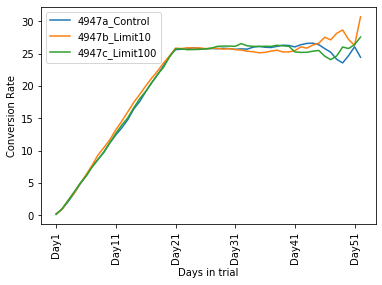

In [16]:
# Plot conversion rates with matplotlib and check result of function

# gca stands for 'get current axis'
ax = plt.gca()

conversionRates.plot(kind='line',y='4947a_Control', ax=ax)
conversionRates.plot(kind='line',y='4947b_Limit10', ax=ax)
conversionRates.plot(kind='line',y='4947c_Limit100', ax=ax)

plt.xlabel('Days in trial')
plt.ylabel('Conversion Rate')
plt.xticks(rotation='vertical')
plt.show()

plt.close()


In [17]:
# Create function to calculate natural log values by day of trial and insert into dataframe
# Conversion on the same day as sign up counts as Convert1

def create_natural_log_values():
    global logValues
    i = 0
    logValues = pd.DataFrame(columns=['Day','logValue'])
    while i <= 59:
        logValues.loc[i] = ['Day'+str(i+1), np.log(i+1)]
        i += 1
    logValues.set_index('Day', inplace=True)
    

In [18]:
# run function to calculate natural log values by day of trial

create_natural_log_values()


In [19]:
# Add column to logValues with the differences between each row of data

logValues['logValueDiff'] = logValues['logValue'].diff()

logValues.head()


,logValue,logValueDiff
Day,,
Day1,0.000000,NaN
Day2,0.693147,0.693147
Day3,1.098612,0.405465
Day4,1.386294,0.287682
Day5,1.609438,0.223144


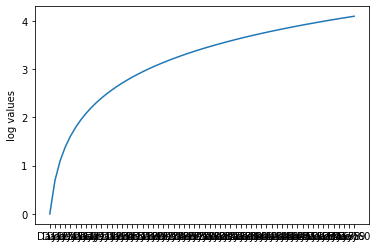

In [20]:
# Plot log values with matplotlib and check result of function

plt.plot(logValues['logValue'])
plt.ylabel('log values')
plt.show()

plt.close()




## MX + B

Old excel model is using slope() and intercept() functions. These functions need to be recreated in python to get the slope and intercept. Here are a few resources on how to do that...

**Slope**
https://support.microsoft.com/en-us/office/slope-function-11fb8f97-3117-4813-98aa-61d7e01276b9

y2 - y1 / x2 - x1

conversion rates / logarithmic values

**M**

To get M, pd.Series().diff needs to be used to get the difference between incremental values. 
This will be done for conversion rates as well as the log values. The result will be M.

https://stackoverflow.com/questions/55192423/calculate-slope-in-dataframe
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.diff.html

**B**
https://support.microsoft.com/en-us/office/intercept-function-2a9b74e2-9d47-4772-b663-3bca70bf63ef

To get B, Using the "slope-intercept" form of the line's equation (y = mx + b), you solve for b (which is the y-intercept you're looking for). Substitute the known slope for m, and substitute the known point's coordinates for x and y, respectively, in the slope-intercept equation. That will let you find b


In [41]:
# Calculate slope (M) values
# https://data36.com/linear-regression-in-python-numpy-polyfit/

# y = conversion rates
# x = log values

#m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
#         ((mean(xs)*mean(xs)) - mean(xs*xs)))

def calculate_slopeValues():
    global slopeDFs
    global slopeValues
    slopeDFs = []
    for u in raw['GROUP_NAME'].unique():
        temp = pd.DataFrame(columns=[u])
        i = 0 # reset to 0
        while i <= 59: # reset to <= 59:
            if (np.mean(logValues['logValue'].iloc[0:i])**2) - np.mean(logValues['logValue'].iloc[0:i]**2) == 0:
                temp.loc[i] =  0
            else:
                temp.loc[i] =  (((np.mean(logValues['logValue'].iloc[0:i])*np.mean(conversionRates[u].iloc[0:i])) - np.mean(logValues['logValue'].iloc[0:i]*conversionRates[u].iloc[0:i])) /
                ((np.mean(logValues['logValue'].iloc[0:i])**2) - np.mean(logValues['logValue'].iloc[0:i]**2)))
            i += 1
        slopeDFs.append(temp)
    slopeValues = pd.concat(slopeDFs, axis=1)
    slopeValues.set_index(logValues.index, inplace=True)
    

In [42]:
# run function to calculate slope values and save to data frame

calculate_slopeValues()


In [48]:
slopeValues.head()


,4947a_Control,4947b_Limit10,4947c_Limit100
Day,,,
Day1,NaN,NaN,NaN
Day2,0,0,0
Day3,1.08427,1.02663,1.26926
Day4,1.65254,1.80669,1.88155
Day5,2.18617,2.25475,2.41162


The equation for the intercept of the regression line, a, is:

a = y - bx

a = day 2 conversion rate - day 2 slope * day 2 log value

where the slope, b, is calculated as:

Equation

and where x and y are the sample means AVERAGE(known_x's) and AVERAGE(known_y's).



In [45]:
# Calculate y intercept values (B)

interceptValues = conversionRates.iloc[:,0:].sub(slopeValues.iloc[:,0:].mul(logValues.iloc[:,0], axis=0))

interceptValues.head()


,4947a_Control,4947b_Limit10,4947c_Limit100
Day1,NaN,NaN,NaN
Day2,0.998121,0.960512,1.04399
Day3,0.946217,1.2093,0.918052
Day4,1.11805,0.924039,1.02093
Day5,1.32456,1.2732,1.07577


In [57]:
# Calculate predicted conversion rates for future days in trial

conversionRatesPredicted = interceptValues.iloc[:,0:].add(slopeValues.iloc[:,0:].mul(logValues['logValue'][-1], axis=0))

conversionRatesPredicted.head()




,4947a_Control,4947b_Limit10,4947c_Limit100
Day1,NaN,NaN,NaN
Day2,0.998121,0.960512,1.04399
Day3,5.38557,5.41269,6.11484
Day4,7.88411,8.32124,8.72466
Day5,10.2755,10.5049,10.9498


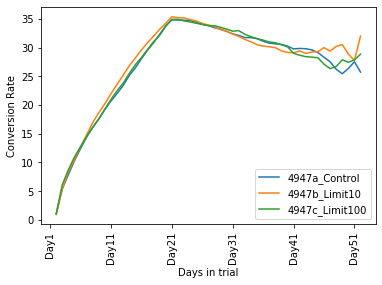

In [60]:
# Plot predicted conversion rates with matplotlib and check result of function

# gca stands for 'get current axis'
ax = plt.gca()

conversionRatesPredicted.plot(kind='line',y='4947a_Control', ax=ax)
conversionRatesPredicted.plot(kind='line',y='4947b_Limit10', ax=ax)
conversionRatesPredicted.plot(kind='line',y='4947c_Limit100', ax=ax)

plt.xlabel('Days in trial')
plt.ylabel('Conversion Rate')
plt.xticks(rotation='vertical')
plt.show()

plt.close()
